In [132]:
import pandas as pd
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [133]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 'fantasy_points_ppr_roll']

In [134]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp["year"] = pbp["game_id"].apply(lambda x: int(x.split("_")[0]))
rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [135]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,carries_roll,rushing_yards_roll,rushing_tds_roll,rushing_first_downs_roll,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,fantasy_points_roll,fantasy_points_ppr_roll
0,82.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
1,156.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
2,201.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
3,222.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,13.000000,54.000000,1.000000,3.000000,4.000000,4.000000,40.000000,0.000000,11.400000,15.400000
4,278.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,22.000000,81.000000,0.000000,6.000000,4.000000,8.000000,6.000000,0.000000,8.700000,12.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204262,3751.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,PHI,home,WAS,...,21.058955,119.855329,0.904718,5.149885,1.928007,2.550645,27.782693,0.165316,20.978281,22.906288
204263,3973.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,6.476085,28.898951,0.067896,1.533212,0.000000,0.000000,0.000000,0.000000,15.084039,15.084039
204264,4000.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,4.279585,13.453497,0.311303,1.154195,0.328729,0.481916,0.471143,0.000000,3.260281,3.589010
204265,4052.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,4.279585,13.453497,0.311303,1.154195,0.328729,0.481916,0.471143,0.000000,3.260281,3.589010


In [136]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [137]:
game_context_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    "defteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    #"wind",
    #"temp",
    'spread_line',
    'total_line'
]


full = ['desc','yards_gained', 'play_end_ydline'] + game_context_cols + rusher_stat_cols

In [138]:
rushes['play_end_ydline'] = (rushes['yardline_100'] - rushes['yards_gained'])
rushes = rushes.loc[~rushes.down.isna()][full].copy(deep=True)

In [139]:
rush_yards_cols = (game_context_cols + rusher_stat_cols)
len(rush_yards_cols)

15

In [140]:
rushes[rush_yards_cols]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,defteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,spread_line,total_line,carries_roll,rushing_yards_roll,fantasy_points_ppr_roll
0,78.0,2.0,0,10.0,0.0,0.0,0.0,864.0,1764.0,3564.0,-3.0,39.5,13.000000,54.000000,15.400000
1,38.0,1.0,0,10.0,0.0,0.0,0.0,772.0,1672.0,3472.0,-3.0,39.5,13.000000,54.000000,15.400000
2,24.0,1.0,0,10.0,0.0,0.0,0.0,701.0,1601.0,3401.0,-3.0,39.5,13.000000,54.000000,15.400000
3,22.0,2.0,0,8.0,0.0,0.0,0.0,663.0,1563.0,3363.0,-3.0,39.5,13.000000,54.000000,15.400000
4,19.0,1.0,0,10.0,0.0,0.0,0.0,626.0,1526.0,3326.0,-3.0,39.5,22.000000,81.000000,12.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204262,39.0,2.0,0,3.0,19.0,10.0,9.0,285.0,285.0,285.0,4.5,49.5,21.058955,119.855329,22.906288
204263,43.0,1.0,0,10.0,10.0,26.0,-16.0,205.0,205.0,205.0,4.5,49.5,6.476085,28.898951,15.084039
204264,38.0,2.0,0,5.0,10.0,26.0,-16.0,199.0,199.0,199.0,4.5,49.5,4.279585,13.453497,3.589010
204265,23.0,2.0,0,1.0,10.0,26.0,-16.0,173.0,173.0,173.0,4.5,49.5,4.279585,13.453497,3.589010


(array([1.9880e+04, 4.9959e+04, 5.9447e+04, 4.7725e+04, 1.9437e+04,
        4.1650e+03, 8.2200e+02, 1.7700e+02, 0.0000e+00, 3.3000e+01]),
 array([-12. ,  12.3,  36.6,  60.9,  85.2, 109.5, 133.8, 158.1, 182.4,
        206.7, 231. ]),
 <BarContainer object of 10 artists>)

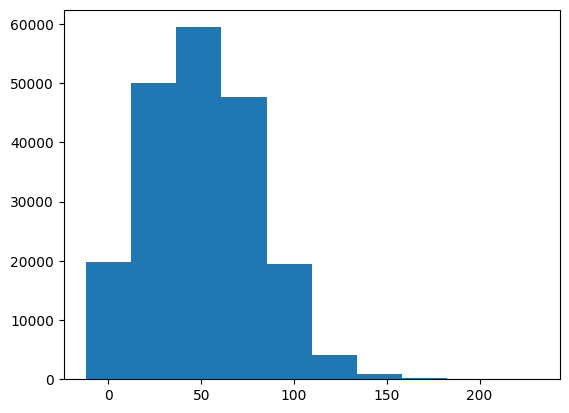

In [141]:
plt.hist(rushes['rushing_yards_roll'])

In [142]:
(game_context_cols + rusher_stat_cols)

['yardline_100',
 'down',
 'goal_to_go',
 'ydstogo',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']

In [143]:
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']].fillna(0)


In [144]:
rush_yards_cols = (game_context_cols + rusher_stat_cols)#[0:3] + [rusher_stat_cols[-1]]
len(rush_yards_cols)

15

In [145]:
rush_yards_cols = [ 'ydstogo',
 'yardline_100',
 'down',
 'goal_to_go',
 'posteam_score',
 'score_differential',
 'spread_line',
 'total_line',
 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll']

In [146]:
rushes['yards_shifted'] = rushes['yards_gained'].apply(lambda x: max(0, (x+5)))

In [147]:

small = rushes.copy(deep=True)

In [148]:

small = rushes#.loc[rushes.yardline_100 < 10]

X = torch.Tensor((small[rush_yards_cols].values))
y = torch.tensor(small['yards_shifted'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(rush_yards_cols)
# Update the model to match the input and output sizes



In [149]:

class ThreeLayerClassifier(nn.Module):
    def __init__(self, input_size=num_feats, hidden_size=30, output_size=106):
        super(ThreeLayerClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size + 1, output_size)  # +1 for the additional feature
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        # Pass through the first two layers
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        # Concatenate the extracted feature with the output of the hidden layers
        x = torch.cat((x, feature_to_pass), dim=1)  # Concatenate along the feature axis (dim=1)
        
        # Pass through the final layer
        x = self.output_layer(x)
        return x



In [150]:

def train_model(X, y):
    # Define the model, loss function, and optimizer
    model = ThreeLayerClassifier()
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Split data into training and testing sets
    train_X, test_X = X[obs//5:], X[:obs//5]
    train_y, test_y = y[obs//5:], y[:obs//5]

    # Training loop
    epochs = 20
    batch_size = 512

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_X)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item()
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return model

model = train_model(X, y)

Epoch 1/20, Loss: 0.0059
Epoch 2/20, Loss: 0.0055
Epoch 3/20, Loss: 0.0055
Epoch 4/20, Loss: 0.0055
Epoch 5/20, Loss: 0.0055
Epoch 6/20, Loss: 0.0055
Epoch 7/20, Loss: 0.0054
Epoch 8/20, Loss: 0.0054
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0054
Epoch 12/20, Loss: 0.0054
Epoch 13/20, Loss: 0.0054
Epoch 14/20, Loss: 0.0054
Epoch 15/20, Loss: 0.0054
Epoch 16/20, Loss: 0.0054
Epoch 17/20, Loss: 0.0054
Epoch 18/20, Loss: 0.0054
Epoch 19/20, Loss: 0.0054
Epoch 20/20, Loss: 0.0054
Test Loss: 2.7746, Test Accuracy: 0.1405


In [ ]:
model_path = "models/run_yards_gained.pt"
torch.save(model.state_dict(), model_path)


feature_config = {
    'rush_yard_cols':rush_yards_cols
}
feature_config

yaml_path = "models/feature_config.yaml"
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)  # Load the current content of the YAML file

# Update the data with the provided updates
data.update(feature_config)

with open(yaml_path, "w") as file:
    yaml.safe_dump(data, file)

{'rush_yard_cols': ['ydstogo',
  'yardline_100',
  'down',
  'goal_to_go',
  'posteam_score',
  'score_differential',
  'spread_line',
  'total_line',
  'carries_roll',
  'rushing_yards_roll',
  'fantasy_points_ppr_roll']}

In [154]:
test = rushes.loc[rushes.yardline_100==1][rush_yards_cols+ ['yards_gained','yards_shifted']]
test

,ydstogo,yardline_100,down,goal_to_go,posteam_score,score_differential,spread_line,total_line,carries_roll,rushing_yards_roll,fantasy_points_ppr_roll,yards_gained,yards_shifted
20,1.0,1.0,1.0,1,3.0,0.0,-3.0,39.5,13.000000,54.000000,15.400000,1.0,6.0
127,1.0,1.0,1.0,1,0.0,-6.0,1.0,36.5,6.000000,-2.000000,4.200000,0.0,5.0
128,1.0,1.0,3.0,1,0.0,-6.0,1.0,36.5,6.000000,-2.000000,4.200000,1.0,6.0
198,1.0,1.0,1.0,1,24.0,8.0,5.5,40.5,12.000000,44.000000,8.500000,-3.0,2.0
252,1.0,1.0,2.0,1,17.0,-21.0,5.0,44.5,15.000000,43.000000,10.400000,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204138,1.0,1.0,3.0,1,7.0,4.0,-6.0,40.0,16.495681,63.330431,11.037490,0.0,5.0
204139,1.0,1.0,1.0,1,7.0,4.0,-6.0,40.0,5.776471,18.890927,16.743384,1.0,6.0
204187,1.0,1.0,2.0,1,6.0,-4.0,6.0,49.0,15.206397,54.189752,15.607315,1.0,6.0
204210,1.0,1.0,1.0,1,0.0,0.0,4.5,49.5,14.400089,61.827142,13.052821,1.0,6.0


In [155]:
model(torch.tensor(test[rush_yards_cols].values.tolist())).argmax(dim=1)

tensor([6, 5, 5,  ..., 6, 6, 6])

torch.Size([1, 11])
torch.Size([106])
torch.Size([1, 11])
torch.Size([106])


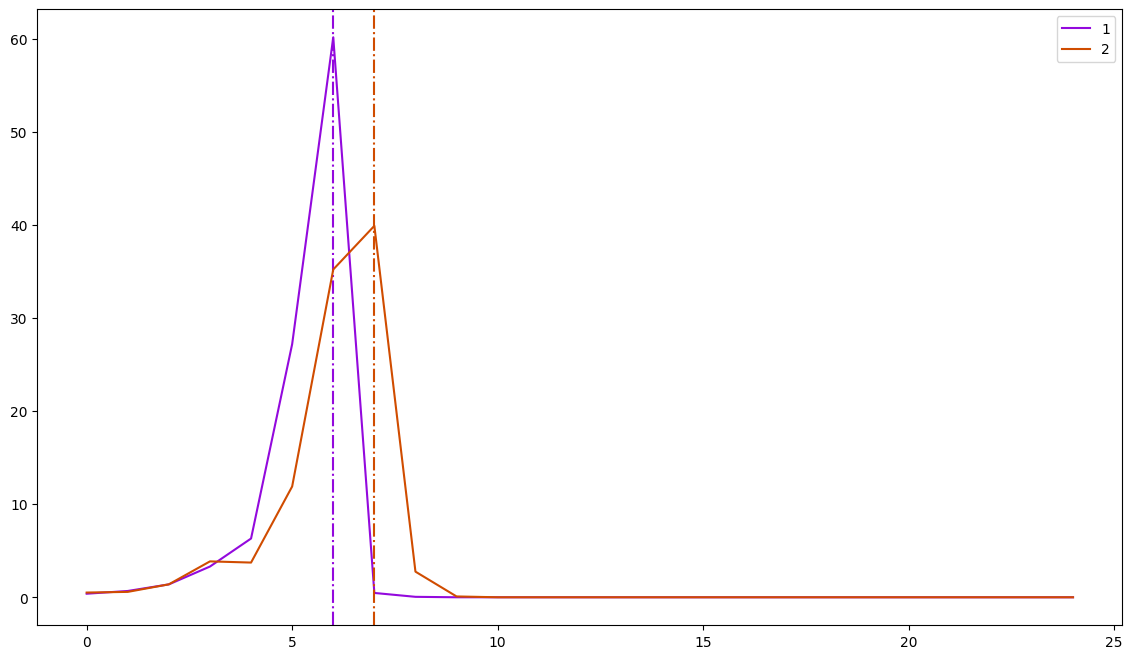

In [156]:
colormap = cm.gnuplot
plt.figure(figsize=(14, 8))
num_yardlines = 3
for yardline in range(1,num_yardlines):
    color = colormap(yardline / num_yardlines) 
    down=1
    test = small.loc[small.yardline_100==yardline]
    xx = torch.Tensor(test[rush_yards_cols].sample(1).values)
    print(xx.shape)
    with torch.no_grad():
        xy = model(xx)
        xy = (100 * F.softmax(xy,dim=1))[0]
        print(xy.shape)
        x_range = range(0,25)
    plt.axvline(yardline + 5, color=color, linestyle='-.')
    plt.plot(x_range, xy[0:25], label=yardline, color=color)

plt.legend()

(array([  505.,   589.,  1428.,     0.,  3896.,  3820.,     0., 11985.,
        35030., 42747.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

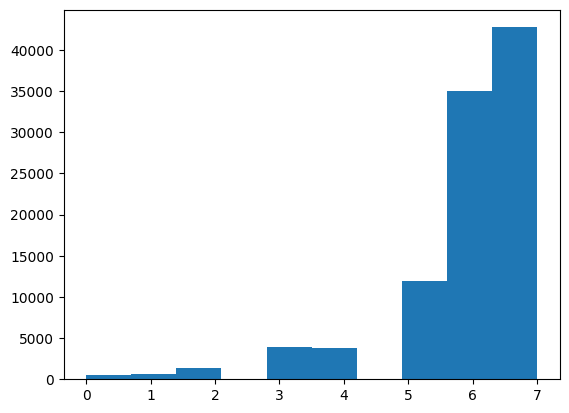

In [157]:
res = model(xx)
res = F.softmax(res,dim=1)[0]
samples = torch.clamp( torch.multinomial(res,100000,replacement=True), max=7)
plt.hist(samples)

<Axes: >

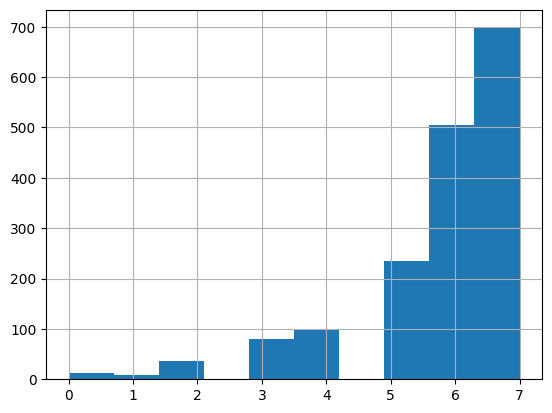

In [158]:
rushes.loc[rushes.yardline_100==2]['yards_shifted'].hist()

In [159]:
[x for x in pbp.columns if 'ard' in x]

['yardline_100',
 'yards_gained',
 'air_yards',
 'yards_after_catch',
 'passing_yards',
 'receiving_yards',
 'rushing_yards',
 'lateral_receiving_yards',
 'lateral_rushing_yards',
 'fumble_recovery_1_yards',
 'fumble_recovery_2_yards',
 'return_yards',
 'penalty_yards',
 'end_yard_line',
 'drive_yards_penalized',
 'drive_start_yard_line',
 'drive_end_yard_line',
 'xyac_mean_yardage',
 'xyac_median_yardage',
 'ngs_air_yards']

In [160]:
pbp.loc[
    (pbp['pass']==1) & 
    (pbp.pass_attempt==1)
    & (pbp.play_type=='run')
    ]['desc']

Series([], Name: desc, dtype: object)

In [161]:
passes = pbp.loc[
        (pbp['pass']==1) & 
    (pbp.pass_attempt==1) & 
    (pbp.air_yards >= -20)
    & (pbp.play_type=='pass')
].copy(deep=True).dropna(axis=1,how='all')

In [163]:
receiver_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[[
    "season",
    "team_name",
    "week",
    "game_type",
    "gsis_id",
    "position",
    "depth_position",
    "full_name",
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
]]

In [164]:
passes = passes.merge(
    receiver_stats,
    left_on=["posteam", "season", "week", "receiver_player_id"],
    right_on=["team_name", "season", "week", "gsis_id"],
)
passes


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,receptions_roll,targets_roll,receiving_yards_roll,receiving_tds_roll,receiving_air_yards_roll,receiving_yards_after_catch_roll,receiving_first_downs_roll,target_share_roll,air_yards_share_roll,fantasy_points_ppr_roll
0,58.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,1.000000
1,103.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,3.000000,15.000000,43.000000,1.000000,226.000000,11.000000,2.000000,0.375000,0.548544,13.300000
2,132.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,4.000000,4.000000,40.000000,0.000000,3.000000,37.000000,2.000000,0.100000,0.007282,15.400000
3,177.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,ARI,away,LA,...,7.000000,7.000000,132.000000,0.000000,72.000000,60.000000,6.000000,0.175000,0.174757,20.200001
4,254.0,2010_01_ARI_STL,2010091208,LA,ARI,REG,1,LA,home,ARI,...,10.000000,16.000000,119.000000,0.000000,162.000000,29.000000,5.000000,0.290909,0.429708,21.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265201,4128.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,2.605394,5.108604,32.947532,0.109419,59.071286,5.681716,1.377177,0.179925,0.323898,6.556662
265202,4158.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,0.328729,0.481916,0.471143,0.000000,-0.091576,0.256344,0.000000,0.018395,-0.000389,3.589010
265203,4183.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,1.972259,3.228922,21.568468,0.000000,20.347308,10.815995,1.038510,0.115135,0.121231,4.129105
265204,4217.0,2024_11_WAS_PHI,2024111400,PHI,WAS,REG,11,WAS,away,PHI,...,4.361904,6.293179,38.894697,0.369205,38.430820,10.789823,2.595845,0.204571,0.190365,11.108083


In [171]:
passes = passes.loc[~passes.receptions_roll.isna()].copy()
#51456 

In [180]:
air_yards_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
] + game_context_cols

In [181]:
passes['target_share_roll'].isna().sum()

0

In [182]:
passes[air_yards_cols].dtypes

dense_depth                         float64
receptions_roll                     float64
targets_roll                        float64
receiving_yards_roll                float64
receiving_tds_roll                  float64
receiving_air_yards_roll            float64
receiving_yards_after_catch_roll    float64
receiving_first_downs_roll          float64
target_share_roll                   float64
air_yards_share_roll                float64
fantasy_points_ppr_roll             float64
yardline_100                        float32
down                                float32
goal_to_go                            int32
ydstogo                             float32
posteam_score                       float32
defteam_score                       float32
score_differential                  float32
quarter_seconds_remaining           float32
half_seconds_remaining              float32
game_seconds_remaining              float32
spread_line                         float32
total_line                      

In [199]:
passes['air_yards_20'] = passes['air_yards'] + 20
X = torch.Tensor((passes[air_yards_cols].values))
y = torch.tensor(passes['air_yards_20'].astype(int).values, dtype=torch.long)
obs = len(X)
num_feats = len(air_yards_cols)
y.shape

torch.Size([263632])

In [200]:

class air_yards_model(nn.Module):
    def __init__(self, input_size=num_feats, hidden_size=30, output_size=119):
        super(air_yards_model, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, hidden_size)
        self.hidden3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size + 1, output_size)  # +1 for the additional feature
    def forward(self, x):
        # Extract the feature to pass to the final layer (e.g., the first feature)
        feature_to_pass = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
        
        # Pass through the first two layers
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        # Concatenate the extracted feature with the output of the hidden layers
        x = torch.cat((x, feature_to_pass), dim=1)  # Concatenate along the feature axis (dim=1)
        
        # Pass through the final layer
        x = self.output_layer(x)
        return x



In [201]:

def train_model(X, y):
    # Define the model, loss function, and optimizer
    model = air_yards_model()
    criterion = nn.CrossEntropyLoss()  # Suitable for classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Split data into training and testing sets
    train_X, test_X = X[obs//5:], X[:obs//5]
    train_y, test_y = y[obs//5:], y[:obs//5]

    # Training loop
    epochs = 10
    batch_size = 512

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(train_X.size(0))
        epoch_loss = 0

        for i in range(0, train_X.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = train_X[indices], train_y[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: [batch_size, 100]
            loss = criterion(outputs, batch_y)  # batch_y must be [batch_size] with class indices
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_X):.4f}")

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_X)  # Shape: [num_samples, 100]
        test_loss = criterion(test_preds, test_y).item()
        accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return model

model = train_model(X, y)

Epoch 1/20, Loss: 0.0148
Epoch 2/20, Loss: 0.0132
Epoch 3/20, Loss: 0.0130
Epoch 4/20, Loss: 0.0130
Epoch 5/20, Loss: 0.0129
Epoch 6/20, Loss: 0.0129
Epoch 7/20, Loss: 0.0129
Epoch 8/20, Loss: 0.0129
Epoch 9/20, Loss: 0.0128
Epoch 10/20, Loss: 0.0128
Epoch 11/20, Loss: 0.0128
Epoch 12/20, Loss: 0.0128
Epoch 13/20, Loss: 0.0128
Epoch 14/20, Loss: 0.0128
Epoch 15/20, Loss: 0.0127
Epoch 16/20, Loss: 0.0127
Epoch 17/20, Loss: 0.0127
Epoch 18/20, Loss: 0.0127
Epoch 19/20, Loss: 0.0127
Epoch 20/20, Loss: 0.0127
Test Loss: 3.2298, Test Accuracy: 0.1025


In [229]:
model_path = "models/air_yards.pt"
torch.save(model.state_dict(), model_path)


feature_config = {
    'air_yards_cols':air_yards_cols
}
feature_config

yaml_path = "models/feature_config.yaml"
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)  # Load the current content of the YAML file

# Update the data with the provided updates
data.update(feature_config)

with open(yaml_path, "w") as file:
    yaml.safe_dump(data, file)